# Plot ali.\*.gz from mono

- 목적: frame당 phone이 정렬되어 있는 ali.\*.gz 파일을 파이썬으로 시각화하기
    - acoustic model이 훈련되면서 (at each alignment), 어떻게 align이 되어가는지를 시각화
- 인풋:
    - ali.\*.gz
    - phones.txt
    - \*.mdl (e.g. 0.mdl, 1.mdl, ... )
    - \*.ark (e.g. raw_mfcc_trans1.1.ark)
- 아웃풋:
    - mfcc w/ phone plot

In [1]:
%matplotlib inline
import IPython
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import os
import re
import glob
import numpy as np
import subprocess

In [2]:
KALDI_HOME= '/home/kaldi'
phones = './align/phones.txt'
wav = './prep_in/lib-0001-fc-008-part.wav'
mfcc = './prep_out/data/data/raw_mfcc_data.1.ark'
ali_gz = './align/ali.1.gz'

## Make prep files

In [3]:
%%bash
. ../make_prep_files/make_prep_data.sh prep_in prep_out

bash prep_in prep_out
Files created in prep_out/data


## Make Lang files

In [4]:
%%bash
. ../make_prep_files/make_lang.sh prep_out

command: bash prep_out
utils/fix_data_dir.sh: file prep_out/data/utt2spk is not in sorted order or not unique, sorting it
utils/fix_data_dir.sh: file prep_out/data/text is not in sorted order or not unique, sorting it
utils/fix_data_dir.sh: file prep_out/data/wav.scp is not in sorted order or not unique, sorting it
fix_data_dir.sh: kept all 11 utterances.
fix_data_dir.sh: old files are kept in prep_out/data/.backup
utils/prepare_lang.sh prep_out/created <unk> prep_out/created/tmp prep_out/lang
Checking prep_out/created/silence_phones.txt ...
--> reading prep_out/created/silence_phones.txt
--> text seems to be UTF-8 or ASCII, checking whitespaces
--> text contains only allowed whitespaces
--> prep_out/created/silence_phones.txt is OK

Checking prep_out/created/optional_silence.txt ...
--> reading prep_out/created/optional_silence.txt
--> text seems to be UTF-8 or ASCII, checking whitespaces
--> text contains only allowed whitespaces
--> prep_out/created/optional_silence.txt is OK

Check

fstaddselfloops prep_out/lang/phones/wdisambig_phones.int prep_out/lang/phones/wdisambig_words.int 
/home/kaldi/src/lmbin/arpa2fst --disambig-symbol=#0 --read-symbol-table=prep_out/lang/words.txt - prep_out/lang/G.fst 
LOG (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:96) Reading \data\ section.
LOG (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:151) Reading \1-grams: section.
WARNING (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:219) line 53 [-2.622214	DESPONDING	-0.07892672] skipped: word 'DESPONDING' not in symbol table
WARNING (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:219) line 69 [-2.622214	FAVOURABLE	-0.07264765] skipped: word 'FAVOURABLE' not in symbol table
WARNING (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:219) line 81 [-2.321184	GREATCOAT	-0.06627648] skipped: word 'GREATCOAT' not in symbol table
WARNING (arpa2fst[5.2.38~1-b82b8]:Read():arpa-file-parser.cc:219) line 194 [-2.622214	UDOLPHO	-0.0684106] skipped: word 'UDOLPHO' not in symb

## Extract MFCCs

In [5]:
%%bash
. ../make_prep_files/make_mfcc_data.sh prep_out

command: bash prep_out
tri1 params on
tri2 params on
tri3 params on
Extracting...  Sat Jan 20 00:14:13 KST 2018
steps/make_mfcc.sh --nj 1 --mfcc-config conf/mfcc.conf --cmd run.pl prep_out/data
utils/validate_data_dir.sh: WARNING: you have only one speaker.  This probably a bad idea.
   Search for the word 'bold' in http://kaldi-asr.org/doc/data_prep.html
   for more information.
Checking prep_out/data/text ...
--> reading prep_out/data/text
--> text seems to be UTF-8 or ASCII, checking whitespaces
--> text contains only allowed whitespaces
utils/validate_data_dir.sh: Successfully validated data-directory prep_out/data
steps/make_mfcc.sh: [info]: no segments file exists: assuming wav.scp indexed by utterance.
Succeeded creating MFCC features for data
steps/compute_cmvn_stats.sh prep_out/data
Succeeded creating CMVN stats for data
fix_data_dir.sh: kept all 11 utterances.
fix_data_dir.sh: old files are kept in prep_out/data/.backup
Finished  Sat Jan 20 00:14:14 KST 2018


## Make alignment files

In [89]:
final_mdl = './align/39.mdl'

In [90]:
%%bash
. ./align_si_from_model.sh --cmd run.pl --nj 1 prep_out/data prep_out/lang models/39 align

# result = subprocess.run(['. ./align_si_from_model.sh --cmd run.pl', '--nj 1','prep_out/data', 'prep_out/lang', final_mdl, 'align'],
#                         stdout=subprocess.PIPE, shell=False)
# print(' '.join(result.args))
# out = result.stdout.decode('utf-8').strip(); out

bash: feature type is delta
bash: aligning data in prep_out/data using model from models/39, putting alignments in align
steps/diagnostic/analyze_alignments.sh --cmd run.pl prep_out/lang align
steps/diagnostic/analyze_alignments.sh: see stats in align/log/analyze_alignments.log
bash: done aligning data.


In [91]:
# TODO: Preprocess alig.*.gz --> ali_dict (align), trim_dict (mfcc)
# retrieve MFCCs
result = subprocess.run([KALDI_HOME+'/src/featbin/copy-feats', 
                        'ark:'+mfcc, 'ark,t:'], stdout=subprocess.PIPE)
out = result.stdout.decode('utf-8').strip()
trim = [i.split('[\n') for i in out.split(']')]
trim = [t for t in trim if t != ['']]

trim_dict = {}
for ii, t in enumerate(trim):
    key = t[0].strip()
    val = [np.array(row.strip().split(' ')).astype(np.float) for row in t[1].split('\n')]
    val = np.array(val)
    trim_dict.update({key: val})

In [92]:
# retrieve ali.*.gz
# proc = subprocess.Popen([KALDI_HOME+'/src/bin/show-alignments', 
#                         phones, final_mdl, '"ark:gunzip -c '+ali_gz+'|"'], 
#                         stdout=subprocess.PIPE, shell=True)
result = subprocess.run([KALDI_HOME+'/src/bin/show-alignments',
                           phones, final_mdl, 'ark:gunzip -c '+ali_gz+'|'],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=False)
print('Commandline: {}'.format(' '.join(result.args)))
out = result.stdout.decode('utf-8').strip()
out = [o for o in out.split('\n') if o != '']

Commandline: /home/kaldi/src/bin/show-alignments ./align/phones.txt ./align/39.mdl ark:gunzip -c ./align/ali.1.gz|


In [93]:
ali_dict = {}
# get nframes from odd number indices
for i, t in enumerate(out[::2]):
    key = t.split('  ')[0].strip()
    frames = [tt.strip(']|[| ').split(' ') for tt in t.split('  ')[1].split('] [')]
    nframes = [len(f) for f in frames]
    ali_dict[key] = {'nframes': nframes}
# get phone labels from even number indices    
for i, t in enumerate(out[1::2]):
    key = t.split('  ')[0].strip()
    labs_raw = re.split(r'\s+', t.strip())[1:]
    labs = [re.sub('_.*','',b) for b in labs_raw] # removing context
    ali_dict[key].update({'labels':labs, 'labels_raw':labs_raw})
# e.g. ali_dict['lib-0001-fc-008-part']['labels']    

In [94]:
ali_dict.keys()

dict_keys(['lib-0001-fc-001', 'lib-0001-fc-002', 'lib-0001-fc-003', 'lib-0001-fc-004', 'lib-0001-fc-005', 'lib-0001-fc-006', 'lib-0001-fc-007', 'lib-0001-fc-008', 'lib-0001-fc-008-part', 'lib-0001-fc-009', 'lib-0001-fc-010'])

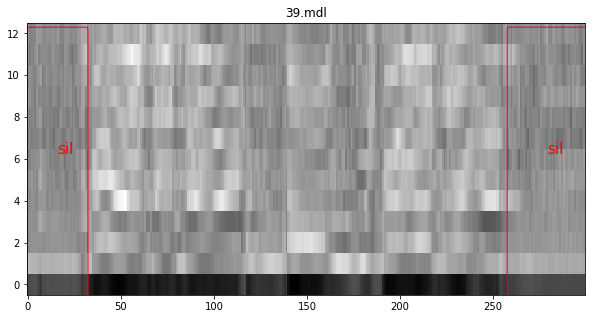

In [96]:
def plot_boxes(fid, ali_dict, trim_dict, title=None, which_lab=None):
    # draw boxes for all phone labels or a single phone
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict)
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, which_lab='sil')
    mfcc = trim_dict[fid] # frame x dim
    nframes = ali_dict[fid]['nframes']
    frames = sum(nframes)
    labels = ali_dict[fid]['labels']
    patch_list = []
    
    fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
    ax.imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')
    ylim = ax.get_ylim()
    if title:
        ax.set_title(title)
    
    if which_lab:
        uq = [which_lab]
        cm_list = ['red']
        
        for q, col in zip(uq, cm_list):
            x = 0
            for frm, lab in zip(nframes, labels):
                if re.match(q, lab):
                    myPatch = patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col)
                    ax.add_patch(myPatch)
                    patch_list.append(myPatch)
                    ax.text(x + frm/2, ylim[1]/2, lab, 
                            color=col, fontsize=15)
                    x += frm
                else:
                    x += frm
        
    else:
        uq = list(set(labels))
        cmap = cm.nipy_spectral
        cm_list = np.linspace(0, 255, len(uq))
        cm_list = np.floor(cm_list).astype(np.int)

        for q, col in zip(uq, cm_list):
            x = 0
            col_hex = matplotlib.colors.rgb2hex(cmap(col))
            pad = np.random.randn()*2
            for frm, lab in zip(nframes, labels):
                if q==lab:
                    ax.add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col_hex))
                    ax.text(x + frm/2, ylim[1]/2+pad, lab, 
                            color=col_hex, fontsize=15)
                    x += frm
                else:
                    x += frm    
    return trim_dict[fid], patch_list
                
img, patch_list = plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, title='39.mdl', which_lab='sil');

## Plot all alignments

In [103]:
%%bash
# make alignments
for i in `ls models`; do
    mkdir -p align/$i
    . ./align_si_from_model.sh --cmd run.pl --nj 1 prep_out/data prep_out/lang models/$i align/$i
    echo '$i is created'
done

bash: feature type is delta
bash: aligning data in prep_out/data using model from models/1, putting alignments in align/1
steps/diagnostic/analyze_alignments.sh --cmd run.pl prep_out/lang align/1
analyze_phone_length_stats.py: WARNING: optional-silence sil is seen only 0.0% of the time at utterance begin.  This may not be optimal.
analyze_phone_length_stats.py: WARNING: optional-silence sil is seen only 9.090909090909092% of the time at utterance end.  This may not be optimal.
steps/diagnostic/analyze_alignments.sh: see stats in align/1/log/analyze_alignments.log
bash: done aligning data.
$i is created
bash: feature type is delta
bash: aligning data in prep_out/data using model from models/10, putting alignments in align/10
steps/diagnostic/analyze_alignments.sh --cmd run.pl prep_out/lang align/10
steps/diagnostic/analyze_alignments.sh: see stats in align/10/log/analyze_alignments.log
bash: done aligning data.
$i is created
bash: feature type is delta
bash: aligning data in prep_out/da

cp: cannot stat 'models/1/1.occs': No such file or directory


In [104]:
def get_ali_dict(phones, final_mdl, ali_gz):
    # retrieve ali.*.gz
    result = subprocess.run([KALDI_HOME+'/src/bin/show-alignments',
                               phones, final_mdl, 'ark:gunzip -c '+ali_gz+'|'],
                               stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=False)
    print('Commandline: {}'.format(' '.join(result.args)))
    out = result.stdout.decode('utf-8').strip()
    out = [o for o in out.split('\n') if o != '']
    
    ali_dict = {}
    # get nframes from odd number indices
    for i, t in enumerate(out[::2]):
        key = t.split('  ')[0].strip()
        frames = [tt.strip(']|[| ').split(' ') for tt in t.split('  ')[1].split('] [')]
        nframes = [len(f) for f in frames]
        ali_dict[key] = {'nframes': nframes}
    # get phone labels from even number indices    
    for i, t in enumerate(out[1::2]):
        key = t.split('  ')[0].strip()
        labs_raw = re.split(r'\s+', t.strip())[1:]
        labs = [re.sub('_.*','',b) for b in labs_raw] # removing context
        ali_dict[key].update({'labels':labs, 'labels_raw':labs_raw})
    # e.g. ali_dict['lib-0001-fc-008-part']['labels']    
    return ali_dict

# final_mdl = './align/2.mdl'
# ali_dict = get_ali_dict(phones, final_mdl, ali_gz)

Commandline: /home/kaldi/src/bin/show-alignments align/1/phones.txt align/1/1.mdl ark:gunzip -c align/1/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/2/phones.txt align/2/2.mdl ark:gunzip -c align/2/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/3/phones.txt align/3/3.mdl ark:gunzip -c align/3/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/4/phones.txt align/4/4.mdl ark:gunzip -c align/4/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/5/phones.txt align/5/5.mdl ark:gunzip -c align/5/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/6/phones.txt align/6/6.mdl ark:gunzip -c align/6/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/7/phones.txt align/7/7.mdl ark:gunzip -c align/7/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/8/phones.txt align/8/8.mdl ark:gunzip -c align/8/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/9/phones.txt align/9/9.mdl ark:gu

/home/zzandore/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Commandline: /home/kaldi/src/bin/show-alignments align/26/phones.txt align/26/26.mdl ark:gunzip -c align/26/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/27/phones.txt align/27/27.mdl ark:gunzip -c align/27/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/28/phones.txt align/28/28.mdl ark:gunzip -c align/28/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/29/phones.txt align/29/29.mdl ark:gunzip -c align/29/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/30/phones.txt align/30/30.mdl ark:gunzip -c align/30/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/31/phones.txt align/31/31.mdl ark:gunzip -c align/31/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/32/phones.txt align/32/32.mdl ark:gunzip -c align/32/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/33/phones.txt align/33/33.mdl ark:gunzip -c align/33/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/3

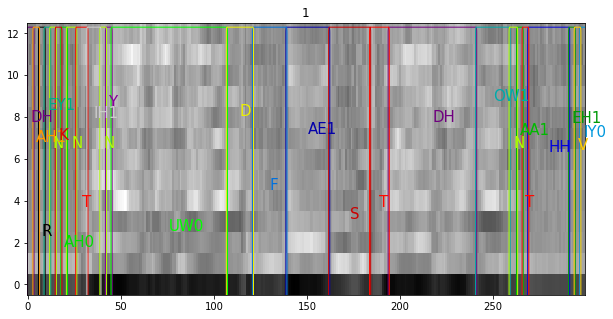

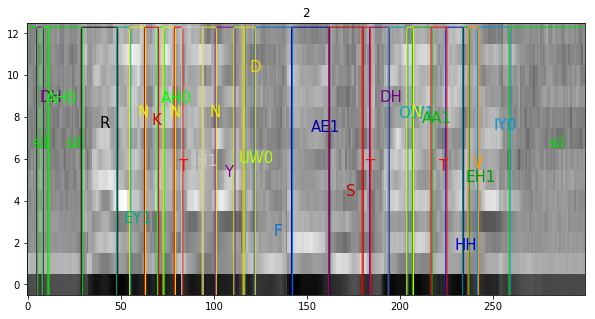

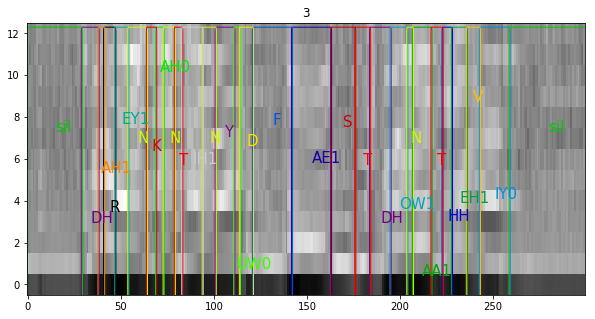

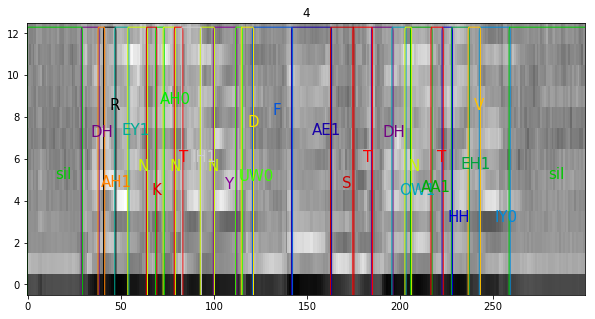

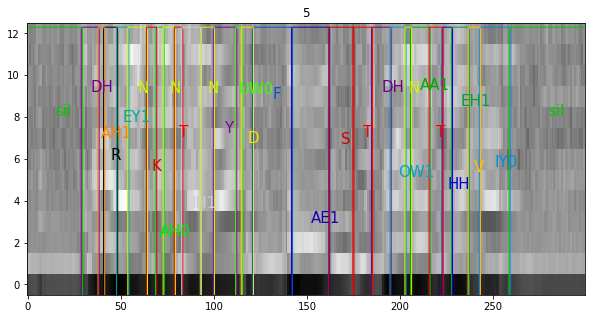

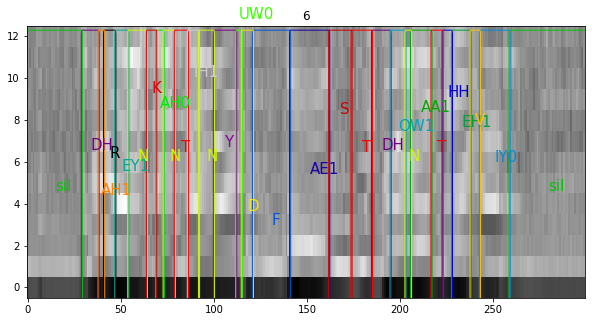

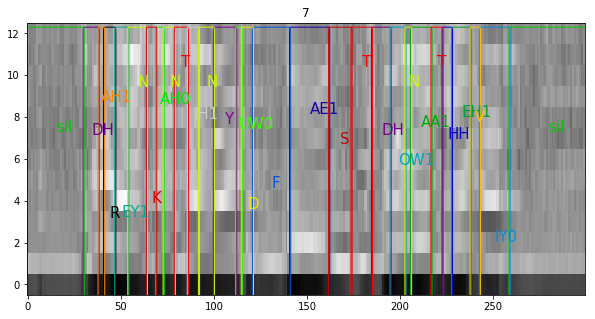

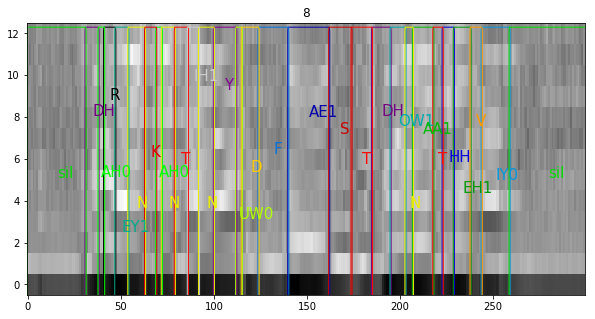

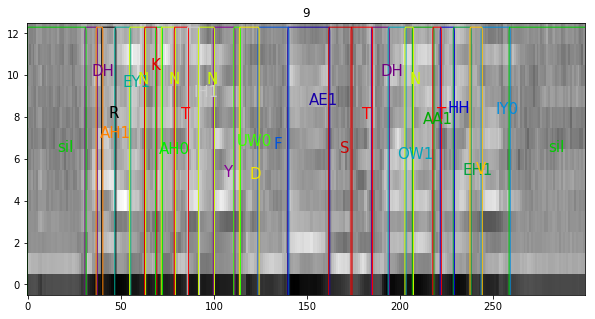

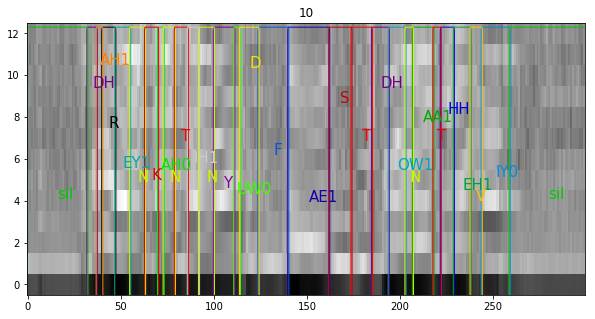

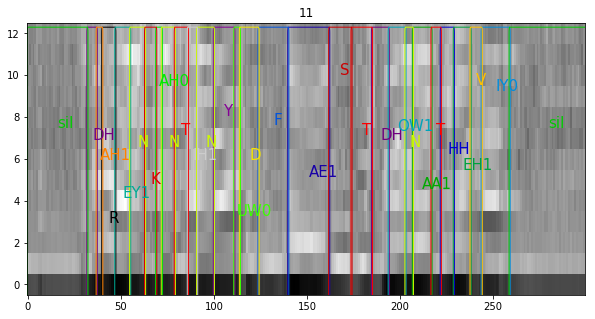

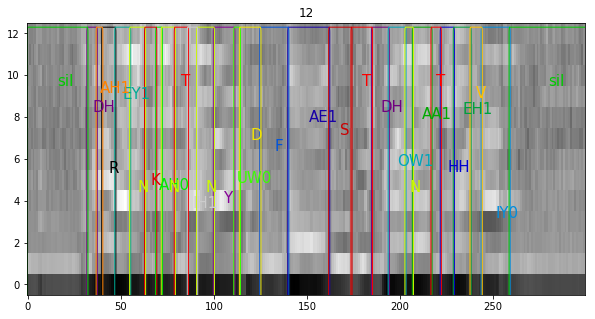

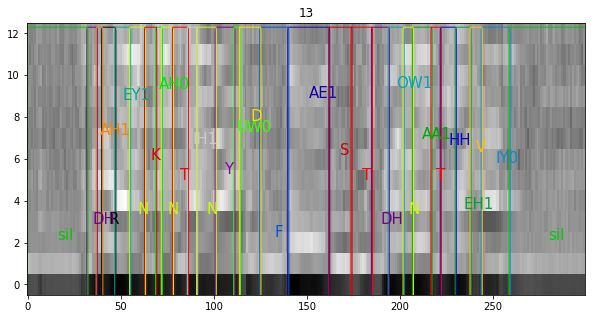

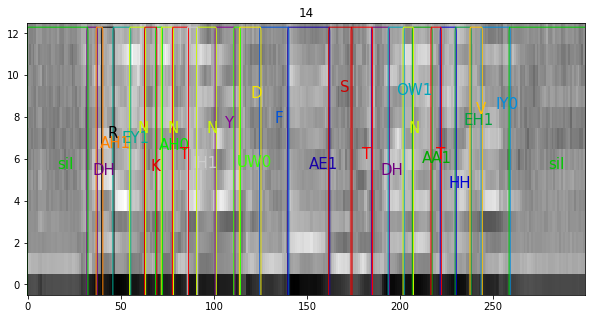

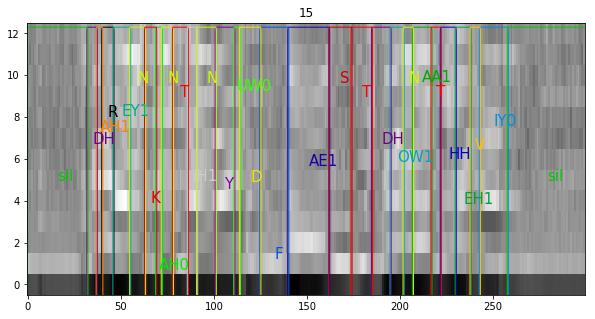

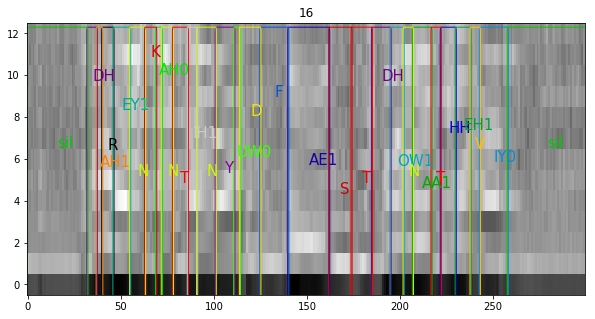

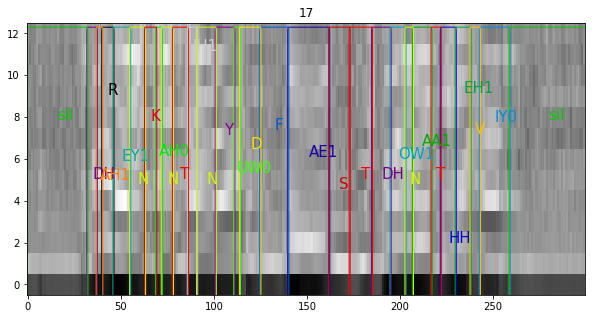

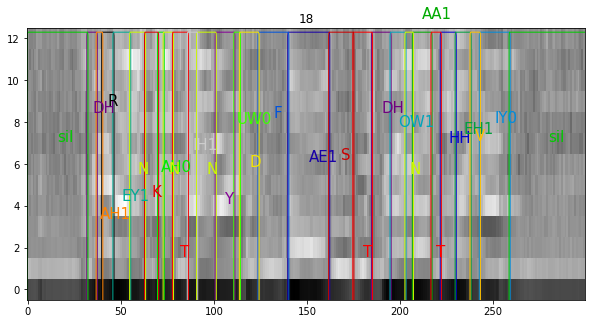

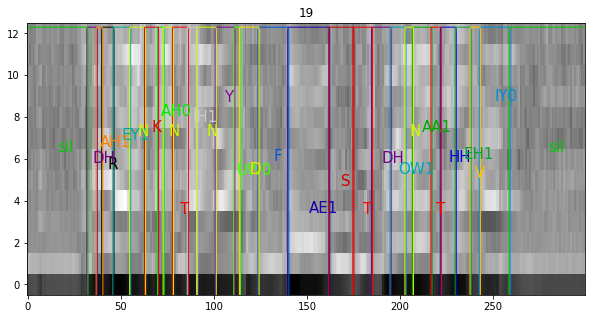

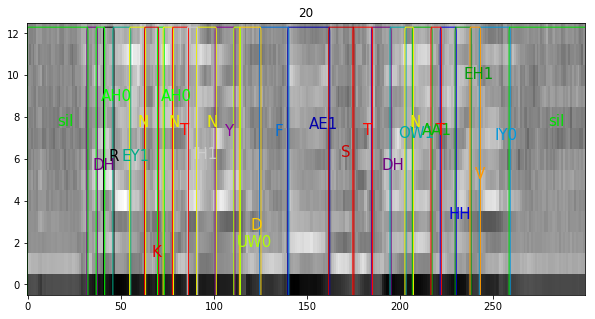

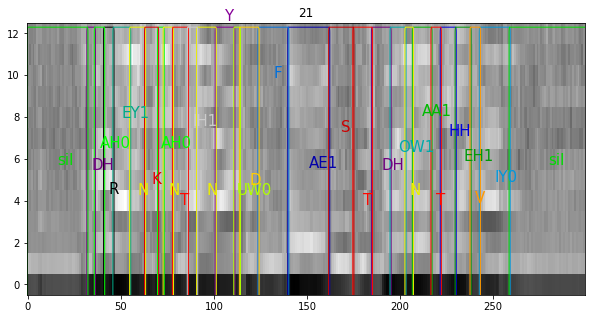

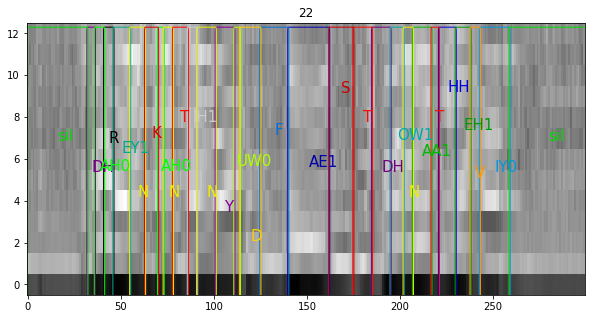

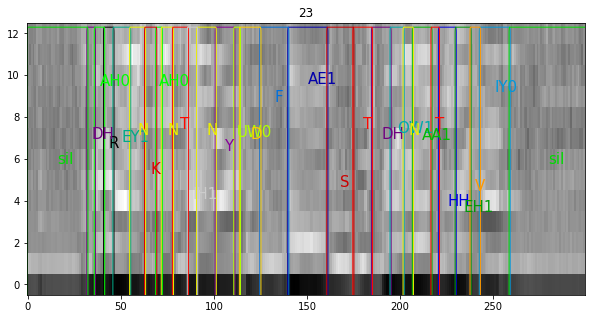

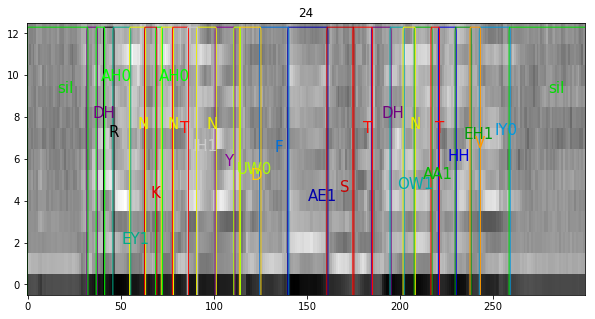

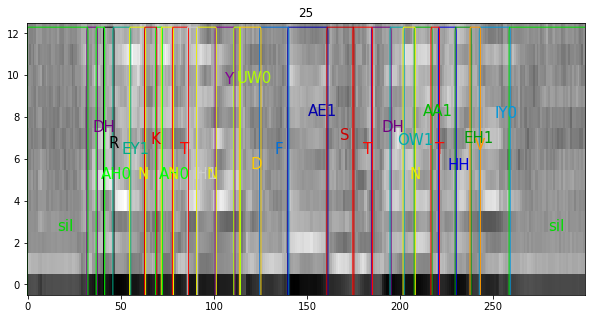

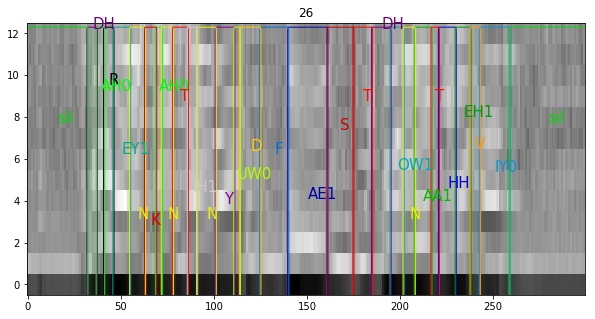

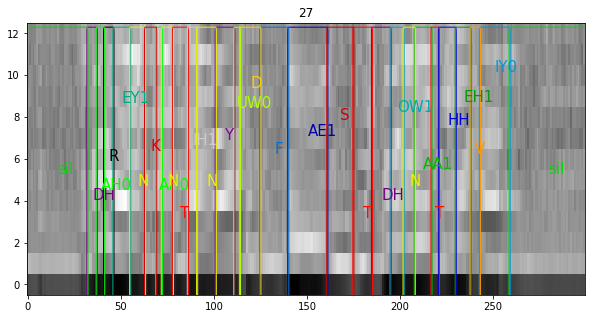

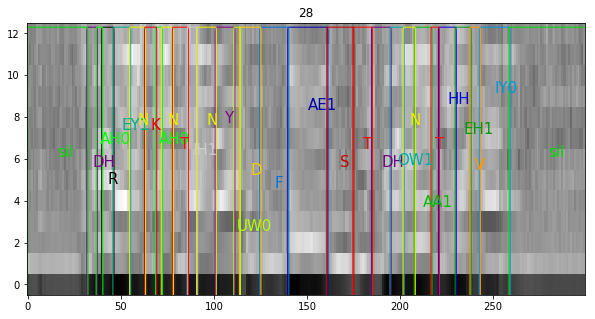

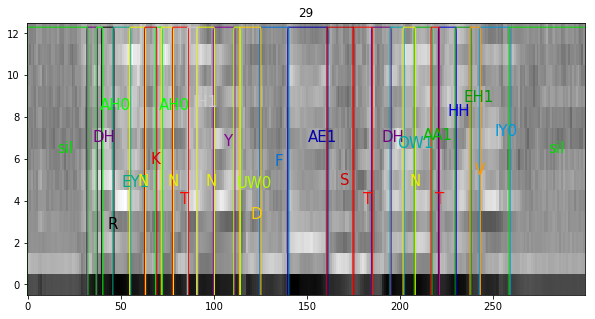

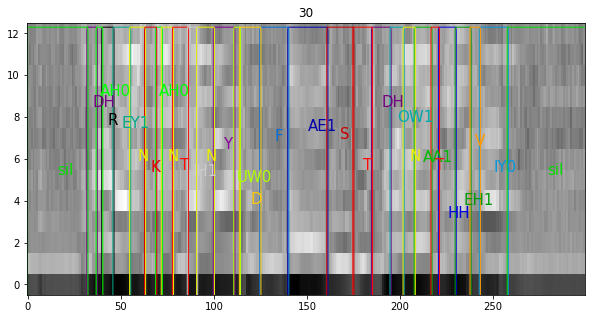

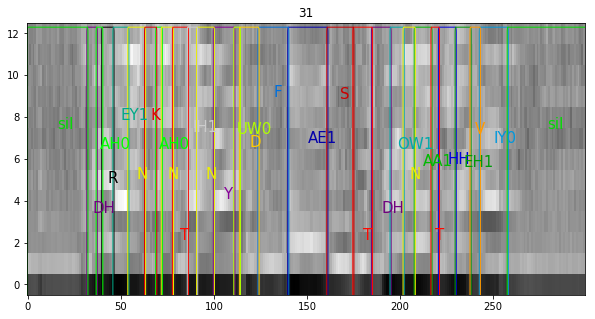

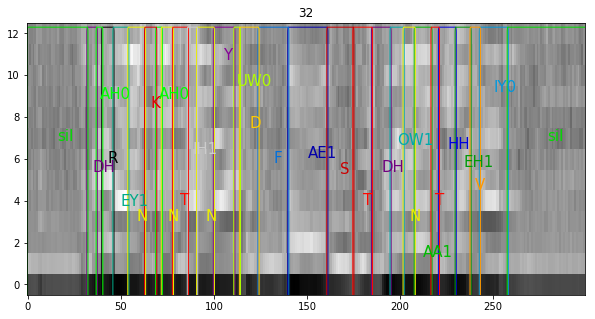

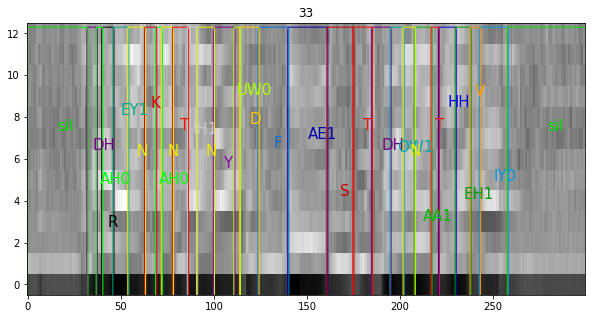

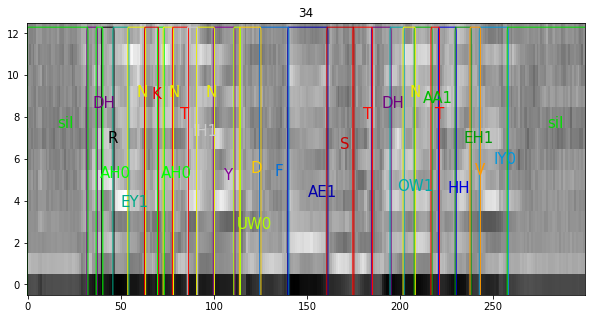

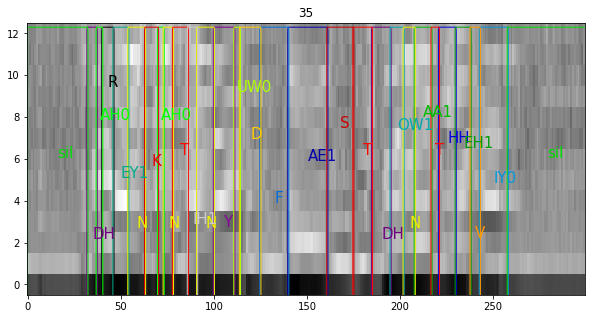

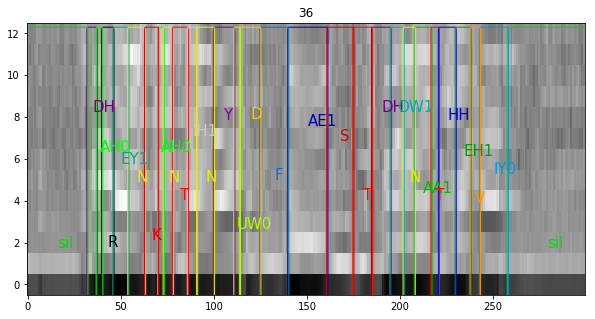

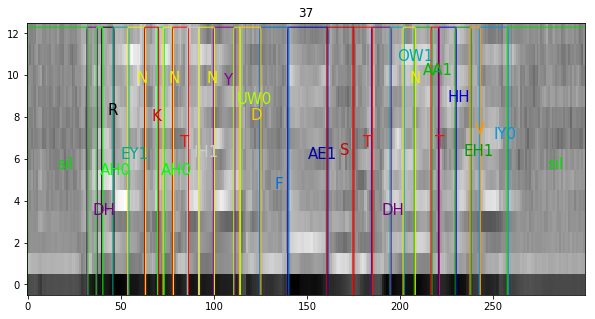

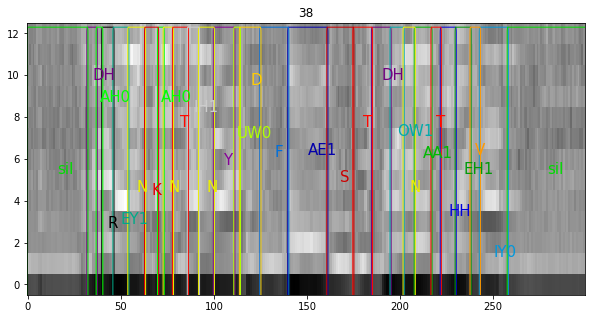

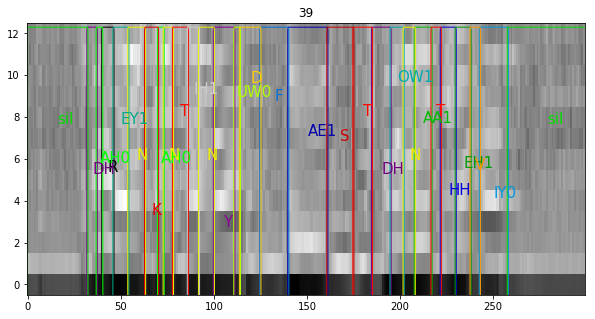

In [111]:
![ -d ./align/log ] && rm -rf ./align/log
ali_dir = sorted([int(name) for name in os.listdir('./align') if os.path.isdir(os.path.join('./align',name))])
alidct_list = []
for i in ali_dir:
    pho = 'align/'+str(i)+'/phones.txt'
    fmd = 'align/'+str(i)+'/'+str(i)+'.mdl'
    ali = 'align/'+str(i)+'/ali.1.gz'
    alidct = get_ali_dict(pho, fmd, ali)
    alidct_list.append(alidct)
#     print(alidict.keys())
    img, patch_list = plot_boxes('lib-0001-fc-008-part', alidct, trim_dict, title=str(i), which_lab=None);